### calculate the leadtime-dependent climatological terciles, deciles and percentiles (0.02, then 0.05 to 0.95 with 0.05 step) from the individual GCMs' hindcast dataset (period 1993 - 2016) for countries 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os and standard libraries 
import os
import sys
from collections import OrderedDict
from itertools import product

### datetimes
from datetime import datetime, timedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns


In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [4]:
sys.path.append('../../') 

In [5]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

### dictionnary holding quantile name and quantile values, they are passed as **lists** to avoid any numerical issues 

In [6]:
dict_quantiles = OrderedDict()
dict_quantiles['tercile'] = [0.3333, 0.6666]
dict_quantiles['decile'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dict_quantiles['percentile'] = [0.02, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95] 

### list of GCMs with complete hindcast period 

In [7]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP']

### list of possible country names (ICU)

In [8]:
country_names = ['New Caledonia',
 'Pitcairn Islands',
 'Papua New Guinea',
 'Solomon Islands',
 'Kiribati: Phoenix Islands',
 'Fiji',
 'Tuvalu',
 'Northern Cook Islands',
 'Kiribati: Line Islands',
 'Federated States of Micronesia',
 'Samoa',
 'Kiribati: Gilbert Islands',
 'Wallis & Futuna',
 'Tokelau',
 'Tuamotu / Gambier Islands',
 'Tonga',
 'Niue',
 'Southern Cook Islands',
 'Austral Islands',
 'Society Islands',
 'Marquesas',
 'Vanuatu South',
 'Vanuatu North',
 'Guam',
 'Northern Marianas',
 'Marshall Islands',
 'Nauru',
 'Palau',
 'American Samoa']

### PARAMETERS

In [9]:
provider = 'CDS'
varname = 'tprate'
period = 'seasonal'
GCM = 'ECMWF'
shape_name = 'Fiji'
quantiles = 'tercile'

In [10]:
# Parameters
GCM = "NCEP"
shape_name = "Papua New Guinea"


### path definitions follow

### figures 

In [11]:
fig_path = CWD.parents[1].joinpath("figures/ICU_validation/")

### outputs 

In [12]:
outputs_path = CWD.parents[1].joinpath("outputs/ICU_validation/")

#### where to find the GCM hindcast datasets 

In [13]:
gcm_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}')

In [14]:
dpath = gcm_path.joinpath(GCM).joinpath(varname.upper())

In [15]:
print(dpath)

/media/nicolasf/END19101/ICU/data/CDS/NCEP/TPRATE


#### where to save the climatologies 

In [16]:
clim_path = gcm_path.joinpath(f'CLIMATOLOGY/{GCM}')

In [17]:
clim_path

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/CLIMATOLOGY/NCEP')

In [18]:
if not clim_path.exists(): 
    
    clim_path.mkdir(parents=True)

### get the list of files 

In [19]:
lfiles = list(dpath.glob(f"ensemble_seas_forecasts_{varname}_from_*_{GCM}.netcdf"))

In [20]:
lfiles.sort()

In [21]:
lfiles[0]

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/NCEP/TPRATE/ensemble_seas_forecasts_tprate_from_1993_01_NCEP.netcdf')

In [22]:
lfiles[-1]

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/NCEP/TPRATE/ensemble_seas_forecasts_tprate_from_2021_04_NCEP.netcdf')

In [23]:
len(lfiles)

305

### open the multiple files dataset, concatenating over the time dimension, and preprocessing 

In [24]:
dset = xr.open_mfdataset(lfiles, preprocess=C3S.preprocess_GCM, parallel=True, engine='netcdf4')

In [25]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (member: 124, time: 305, lon: 126, lat: 86, step: 5)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 ... 116 117 118 119 120 121 122 123
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2021-04-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 242.0 243.0 244.0 245.0
  * lat      (lat) float32 -55.0 -54.0 -53.0 -52.0 -51.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 1 2 3 4 5
Data variables:
    tprate   (time, step, member, lat, lon) float32 dask.array<chunksize=(1, 5, 124, 86, 126), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 20:10:36 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

### print the number of members in the ensemble for each time step 

In [26]:
# for t in range(len(dset.time)): 
    
#     s = dset.isel(time=t)
    
#     print(f"{pd.to_datetime(dset.isel(time=t)['time'].data):%Y-%m}:", len(s.dropna('member')['member']))

### selects the hindcast period 

In [27]:
dset = dset.sel(time=slice('1993', '2016'))

In [28]:
dset

,Array,Chunk
Bytes,7.21 GiB,25.63 MiB
Shape,"(288, 5, 124, 86, 126)","(1, 5, 124, 86, 126)"
Count,2747 Tasks,288 Chunks
Type,float32,numpy.ndarray


### convert to monthly rainfall accumulations (mm/month)

In [29]:
dset.tprate.attrs

{'units': 'm s**-1', 'long_name': 'Mean total precipitation rate'}

In [30]:
dset = C3S.convert_rainfall(dset, varin='tprate', varout='precip', leadvar='step', timevar='time', dropvar=True)


unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip


In [31]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (member: 124, time: 288, lon: 126, lat: 86, step: 5)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 ... 116 117 118 119 120 121 122 123
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 242.0 243.0 244.0 245.0
  * lat      (lat) float32 -55.0 -54.0 -53.0 -52.0 -51.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 1 2 3 4 5
Data variables:
    precip   (time, step, member, lat, lon) float64 dask.array<chunksize=(1, 5, 124, 86, 126), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 20:10:36 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

In [32]:
dset.precip.attrs

{'units': 'mm/month'}

### make sure there are no negative values 

In [33]:
dset = dset.clip(min=0)

### if the period is set to `seasonal`, calculates the seasonal accumulations 

In [34]:
if period == 'seasonal': 
    
    dset = dset.rolling({'step':3}, min_periods=3).sum('step')
    
    dset = dset.sel({'step':slice(3, None)})

In [35]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (member: 124, time: 288, lon: 126, lat: 86, step: 3)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 ... 116 117 118 119 120 121 122 123
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 242.0 243.0 244.0 245.0
  * lat      (lat) float32 -55.0 -54.0 -53.0 -52.0 -51.0 ... 27.0 28.0 29.0 30.0
  * step     (step) int64 3 4 5
Data variables:
    precip   (time, step, member, lat, lon) float64 dask.array<chunksize=(1, 3, 124, 86, 126), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 20:10:36 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...>

In [36]:
steps = dset.step.data

In [37]:
steps

array([3, 4, 5])

### calculate percentiles over the dimensions member and time, will then be lead time dependent 

In [38]:
def calc_percentiles(dset, percentiles=None, dims=['member','time']):
    """
    calculates the climatological percentiles, over dimensions 
    ['member','time'] from a CDS hindcast dataset 
    
    Arguments
    ---------
    
    Returns
    -------
    """
    if percentiles is None: 
        
        percentiles = np.insert(np.arange(0.05, 1., 0.05), 0, 0.02)
        
    return dset.quantile(percentiles, dim=dims) 

In [39]:
# coastlines_dpath = '/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles'


In [40]:
coastlines_dpath = pathlib.Path('/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/ICU/') 

In [41]:
shapefile = gpd.read_file(coastlines_dpath.joinpath('ICU_coastlines_geometries0_360.shp'))

In [42]:
shapefile.head(3)

,OBJECTID,COUNTRY_ID,COUNTRYNAM,ICU,Stress,SOPAC,FFA,SPC,SPREP,USP,TCSP,FORUM,ACP,area,Shape_Leng,Shape_Area,geometry
0,1.0,NC,New Caledonia,2.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.331204,1.639128,"MULTIPOLYGON (((166.933 -22.882, 166.933 -22.8..."
1,2.0,PN,Pitcairn Islands,-3.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.733043,0.004720,"MULTIPOLYGON (((229.905 -25.069, 229.905 -25.0..."
2,3.0,PG,Papua New Guinea,-3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.361133,37.800908,"MULTIPOLYGON (((153.509 -11.620, 153.508 -11.6..."


In [43]:
shapefile.columns

Index(['OBJECTID', 'COUNTRY_ID', 'COUNTRYNAM', 'ICU', 'Stress', 'SOPAC', 'FFA',
       'SPC', 'SPREP', 'USP', 'TCSP', 'FORUM', 'ACP', 'area', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')

In [44]:
location_col = 'COUNTRYNAM'

In [45]:
shape = shapefile.query(f"{location_col} == '{shape_name}'")

In [46]:
if not(shape.crs): 
    print("setting CRS")
    shape = shape.set_crs("EPSG:4326")

setting CRS


<AxesSubplot:>

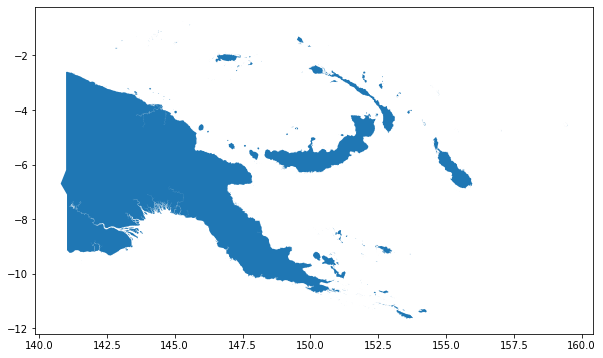

In [47]:
shape.plot(figsize=(10,10))

In [48]:
original_shape = shape.copy()

### for Island groups consituted of very small islands / atolls, we don't filter OUT the geometries, we actually buffer them  so that they can match the resolution of the GCM (once interpolated)

In [49]:
float(shape.to_crs('EPSG:3857').area / 10**6)

471683.6982886551

In [50]:
if float(shape.to_crs('EPSG:3857').area / 10**6) < 1000: 
    shape = shape.buffer(0.25)
else: 
    shape = geo.filter_by_area(shape, min_area=500)

<AxesSubplot:>

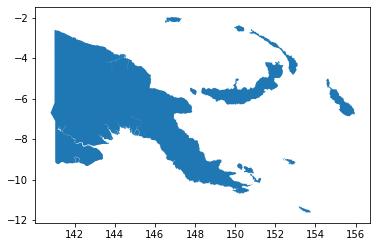

In [51]:
shape.plot()

### we use these filtered geometries to mask the GCM hindcast dataset

#### Note that the GCM dataset is first interpolated to 5X its original resolution 

In [52]:
dset

,Array,Chunk
Bytes,8.65 GiB,30.75 MiB
Shape,"(288, 3, 124, 86, 126)","(1, 3, 124, 86, 126)"
Count,12538 Tasks,288 Chunks
Type,float64,numpy.ndarray


In [53]:
dset, domain = geo.mask_dataset(dset, shape, coastline_buffer=15)

[                                        ] | 0% Completed |  0.0s

[                                        ] | 0% Completed |  0.2s

[                                        ] | 0% Completed |  0.3s

[                                        ] | 0% Completed |  0.4s

[                                        ] | 1% Completed |  0.5s

[#                                       ] | 4% Completed |  0.6s

[##                                      ] | 6% Completed |  0.7s

[###                                     ] | 7% Completed |  0.8s

[###                                     ] | 8% Completed |  0.9s

[####                                    ] | 10% Completed |  1.0s

[####                                    ] | 11% Completed |  1.1s

[#####                                   ] | 12% Completed |  1.2s

[#####                                   ] | 13% Completed |  1.3s

[#####                                   ] | 13% Completed |  1.5s

[#####                                   ] | 14% Completed |  1.6s

[#####                                   ] | 14% Completed |  1.7s

[######                                  ] | 15% Completed |  1.9s

[######                                  ] | 15% Completed |  2.0s

[######                                  ] | 16% Completed |  2.1s

[######                                  ] | 16% Completed |  2.2s

[#########                               ] | 23% Completed |  2.4s

[#########                               ] | 24% Completed |  2.5s

[##########                              ] | 25% Completed |  2.6s

[##########                              ] | 26% Completed |  2.7s

[##########                              ] | 26% Completed |  2.8s

[##########                              ] | 26% Completed |  2.9s

[##########                              ] | 26% Completed |  3.1s

[##########                              ] | 26% Completed |  3.2s

[##########                              ] | 27% Completed |  3.3s

[##########                              ] | 27% Completed |  3.4s

[###########                             ] | 27% Completed |  3.5s

[###########                             ] | 29% Completed |  3.6s

[###########                             ] | 29% Completed |  3.8s

[###########                             ] | 29% Completed |  3.9s

[############                            ] | 30% Completed |  4.0s

[############                            ] | 30% Completed |  4.1s

[############                            ] | 30% Completed |  4.3s

[############                            ] | 31% Completed |  4.4s

[############                            ] | 31% Completed |  4.5s

[############                            ] | 31% Completed |  4.7s

[############                            ] | 32% Completed |  4.8s

[############                            ] | 32% Completed |  4.9s

[#############                           ] | 32% Completed |  5.0s

[#############                           ] | 32% Completed |  5.2s

[#############                           ] | 32% Completed |  5.3s

[#############                           ] | 32% Completed |  5.4s

[#############                           ] | 32% Completed |  5.5s

[#############                           ] | 32% Completed |  5.6s

[#############                           ] | 32% Completed |  5.7s

[#############                           ] | 33% Completed |  5.8s

[#############                           ] | 33% Completed |  6.0s

[#############                           ] | 33% Completed |  6.1s

[#############                           ] | 33% Completed |  6.2s

[#############                           ] | 33% Completed |  6.3s

[#############                           ] | 33% Completed |  6.4s

[#############                           ] | 33% Completed |  6.5s

[#############                           ] | 33% Completed |  6.6s

[#############                           ] | 33% Completed |  6.7s

[#############                           ] | 33% Completed |  6.8s

[#############                           ] | 33% Completed |  6.9s

[#############                           ] | 33% Completed |  7.0s

[#############                           ] | 33% Completed |  7.1s

[#############                           ] | 33% Completed |  7.2s

[#############                           ] | 33% Completed |  7.3s

[#############                           ] | 33% Completed |  7.4s

[#############                           ] | 34% Completed |  7.5s

[#############                           ] | 34% Completed |  7.7s

[#############                           ] | 34% Completed |  7.8s

[#############                           ] | 34% Completed |  7.9s

[#############                           ] | 34% Completed |  8.0s

[#############                           ] | 34% Completed |  8.1s

[#############                           ] | 34% Completed |  8.2s

[#############                           ] | 34% Completed |  8.3s

[#############                           ] | 34% Completed |  8.4s

[#############                           ] | 34% Completed |  8.6s

[#############                           ] | 34% Completed |  8.7s

[#############                           ] | 34% Completed |  8.8s

[#############                           ] | 34% Completed |  8.9s

[#############                           ] | 34% Completed |  9.0s

[#############                           ] | 34% Completed |  9.1s

[#############                           ] | 34% Completed |  9.2s

[#############                           ] | 34% Completed |  9.3s

[#############                           ] | 34% Completed |  9.4s

[#############                           ] | 34% Completed |  9.5s

[#############                           ] | 34% Completed |  9.7s

[#############                           ] | 34% Completed |  9.8s

[##############                          ] | 35% Completed |  9.9s

[##############                          ] | 35% Completed | 10.0s

[##############                          ] | 35% Completed | 10.1s

[##############                          ] | 35% Completed | 10.2s

[##############                          ] | 36% Completed | 10.3s

[##############                          ] | 36% Completed | 10.4s

[##############                          ] | 36% Completed | 10.5s

[##############                          ] | 36% Completed | 10.6s

[##############                          ] | 36% Completed | 10.7s

[##############                          ] | 36% Completed | 10.8s

[##############                          ] | 36% Completed | 10.9s

[##############                          ] | 37% Completed | 11.0s

[###############                         ] | 37% Completed | 11.1s

[###############                         ] | 37% Completed | 11.2s

[###############                         ] | 38% Completed | 11.3s

[###############                         ] | 38% Completed | 11.5s

[###############                         ] | 38% Completed | 11.6s

[###############                         ] | 38% Completed | 11.7s

[###############                         ] | 38% Completed | 11.8s

[###############                         ] | 38% Completed | 11.9s

[###############                         ] | 39% Completed | 12.0s

[###############                         ] | 39% Completed | 12.1s

[###############                         ] | 39% Completed | 12.3s

[###############                         ] | 39% Completed | 12.4s

[###############                         ] | 39% Completed | 12.5s

[###############                         ] | 39% Completed | 12.6s

[################                        ] | 40% Completed | 12.7s

[################                        ] | 40% Completed | 12.8s

[################                        ] | 40% Completed | 12.9s

[################                        ] | 40% Completed | 13.0s

[################                        ] | 41% Completed | 13.1s

[#################                       ] | 43% Completed | 13.3s

[#################                       ] | 44% Completed | 13.4s

[#################                       ] | 44% Completed | 13.5s

[#################                       ] | 44% Completed | 13.6s

[#################                       ] | 44% Completed | 13.7s

[##################                      ] | 45% Completed | 13.8s

[##################                      ] | 45% Completed | 13.9s

[##################                      ] | 45% Completed | 14.0s

[##################                      ] | 46% Completed | 14.1s

[##################                      ] | 46% Completed | 14.2s

[##################                      ] | 46% Completed | 14.3s

[##################                      ] | 47% Completed | 14.4s

[###################                     ] | 47% Completed | 14.5s

[###################                     ] | 47% Completed | 14.7s

[###################                     ] | 48% Completed | 14.8s

[###################                     ] | 48% Completed | 14.9s

[###################                     ] | 48% Completed | 15.0s

[###################                     ] | 48% Completed | 15.1s

[###################                     ] | 49% Completed | 15.2s

[###################                     ] | 49% Completed | 15.3s

[###################                     ] | 49% Completed | 15.4s

[####################                    ] | 50% Completed | 15.5s

[####################                    ] | 50% Completed | 15.6s

[####################                    ] | 51% Completed | 15.7s

[####################                    ] | 51% Completed | 15.8s

[####################                    ] | 52% Completed | 15.9s

[#####################                   ] | 52% Completed | 16.1s

[#####################                   ] | 53% Completed | 16.2s

[#####################                   ] | 53% Completed | 16.3s

[#####################                   ] | 54% Completed | 16.4s

[#####################                   ] | 54% Completed | 16.5s

[######################                  ] | 55% Completed | 16.6s

[######################                  ] | 55% Completed | 16.7s

[######################                  ] | 55% Completed | 16.9s

[######################                  ] | 56% Completed | 17.0s

[######################                  ] | 56% Completed | 17.1s

[######################                  ] | 56% Completed | 17.2s

[######################                  ] | 57% Completed | 17.3s

[######################                  ] | 57% Completed | 17.4s

[#######################                 ] | 57% Completed | 17.6s

[#######################                 ] | 57% Completed | 17.7s

[#######################                 ] | 58% Completed | 17.8s

[#######################                 ] | 58% Completed | 17.9s

[#######################                 ] | 59% Completed | 18.0s

[#######################                 ] | 59% Completed | 18.2s

[#######################                 ] | 59% Completed | 18.3s

[########################                ] | 60% Completed | 18.4s

[########################                ] | 60% Completed | 18.5s

[########################                ] | 61% Completed | 18.6s

[########################                ] | 61% Completed | 18.7s

[#########################               ] | 64% Completed | 18.8s

[#########################               ] | 64% Completed | 18.9s

[##########################              ] | 65% Completed | 19.1s

[##########################              ] | 66% Completed | 19.2s

[##########################              ] | 66% Completed | 19.3s

[###########################             ] | 68% Completed | 19.4s

[###########################             ] | 69% Completed | 19.5s

[###########################             ] | 69% Completed | 19.6s

[###########################             ] | 69% Completed | 19.7s

[###########################             ] | 69% Completed | 19.8s

[###########################             ] | 69% Completed | 19.9s

[###########################             ] | 69% Completed | 20.0s

[###########################             ] | 69% Completed | 20.1s

[############################            ] | 70% Completed | 20.3s

[############################            ] | 70% Completed | 20.4s

[############################            ] | 70% Completed | 20.5s

[############################            ] | 70% Completed | 20.6s

[############################            ] | 70% Completed | 20.7s

[############################            ] | 70% Completed | 20.8s

[############################            ] | 70% Completed | 20.9s

[############################            ] | 71% Completed | 21.0s

[############################            ] | 71% Completed | 21.2s

[############################            ] | 71% Completed | 21.3s

[############################            ] | 71% Completed | 21.4s

[############################            ] | 71% Completed | 21.5s

[############################            ] | 71% Completed | 21.6s

[############################            ] | 71% Completed | 21.7s

[############################            ] | 72% Completed | 21.8s

[############################            ] | 72% Completed | 21.9s

[############################            ] | 72% Completed | 22.0s

[############################            ] | 72% Completed | 22.1s

[############################            ] | 72% Completed | 22.2s

[############################            ] | 72% Completed | 22.3s

[#############################           ] | 72% Completed | 22.4s

[#############################           ] | 72% Completed | 22.5s

[#############################           ] | 72% Completed | 22.6s

[#############################           ] | 72% Completed | 22.7s

[#############################           ] | 72% Completed | 22.8s

[#############################           ] | 72% Completed | 22.9s

[#############################           ] | 72% Completed | 23.0s

[#############################           ] | 72% Completed | 23.1s

[#############################           ] | 72% Completed | 23.2s

[#############################           ] | 73% Completed | 23.4s

[#############################           ] | 73% Completed | 23.5s

[#############################           ] | 73% Completed | 23.6s

[#############################           ] | 73% Completed | 23.7s

[#############################           ] | 73% Completed | 23.8s

[#############################           ] | 73% Completed | 23.9s

[#############################           ] | 73% Completed | 24.0s

[#############################           ] | 73% Completed | 24.1s

[#############################           ] | 73% Completed | 24.2s

[#############################           ] | 73% Completed | 24.3s

[#############################           ] | 73% Completed | 24.4s

[#############################           ] | 73% Completed | 24.6s

[#############################           ] | 73% Completed | 24.7s

[#############################           ] | 74% Completed | 24.8s

[#############################           ] | 74% Completed | 24.9s

[#############################           ] | 74% Completed | 25.0s

[#############################           ] | 74% Completed | 25.1s

[#############################           ] | 74% Completed | 25.2s

[#############################           ] | 74% Completed | 25.3s

[#############################           ] | 74% Completed | 25.4s

[#############################           ] | 74% Completed | 25.5s

[#############################           ] | 74% Completed | 25.6s

[#############################           ] | 74% Completed | 25.7s

[#############################           ] | 74% Completed | 25.8s

[#############################           ] | 74% Completed | 25.9s

[#############################           ] | 74% Completed | 26.0s

[##############################          ] | 75% Completed | 26.2s

[##############################          ] | 75% Completed | 26.3s

[##############################          ] | 75% Completed | 26.4s

[##############################          ] | 75% Completed | 26.5s

[##############################          ] | 75% Completed | 26.6s

[##############################          ] | 75% Completed | 26.7s

[##############################          ] | 75% Completed | 26.9s

[##############################          ] | 75% Completed | 27.0s

[##############################          ] | 75% Completed | 27.1s

[##############################          ] | 75% Completed | 27.2s

[##############################          ] | 75% Completed | 27.3s

[##############################          ] | 75% Completed | 27.4s

[##############################          ] | 75% Completed | 27.5s

[##############################          ] | 75% Completed | 27.6s

[##############################          ] | 75% Completed | 27.7s

[##############################          ] | 75% Completed | 27.8s

[##############################          ] | 76% Completed | 27.9s

[##############################          ] | 76% Completed | 28.1s

[##############################          ] | 76% Completed | 28.2s

[##############################          ] | 76% Completed | 28.3s

[##############################          ] | 76% Completed | 28.4s

[##############################          ] | 76% Completed | 28.6s

[##############################          ] | 76% Completed | 28.7s

[##############################          ] | 76% Completed | 28.8s

[##############################          ] | 76% Completed | 28.9s

[##############################          ] | 76% Completed | 29.0s

[##############################          ] | 76% Completed | 29.1s

[##############################          ] | 76% Completed | 29.2s

[##############################          ] | 76% Completed | 29.3s

[##############################          ] | 76% Completed | 29.4s

[##############################          ] | 77% Completed | 29.6s

[##############################          ] | 77% Completed | 29.7s

[##############################          ] | 77% Completed | 29.8s

[##############################          ] | 77% Completed | 29.9s

[##############################          ] | 77% Completed | 30.0s

[##############################          ] | 77% Completed | 30.1s

[##############################          ] | 77% Completed | 30.2s

[##############################          ] | 77% Completed | 30.3s

[##############################          ] | 77% Completed | 30.5s

[##############################          ] | 77% Completed | 30.6s

[##############################          ] | 77% Completed | 30.7s

[###############################         ] | 77% Completed | 30.8s

[###############################         ] | 77% Completed | 30.9s

[###############################         ] | 77% Completed | 31.0s

[###############################         ] | 77% Completed | 31.1s

[###############################         ] | 77% Completed | 31.2s

[###############################         ] | 77% Completed | 31.3s

[###############################         ] | 77% Completed | 31.4s

[###############################         ] | 77% Completed | 31.6s

[###############################         ] | 77% Completed | 31.7s

[###############################         ] | 78% Completed | 31.8s

[###############################         ] | 78% Completed | 31.9s

[###############################         ] | 78% Completed | 32.0s

[###############################         ] | 78% Completed | 32.1s

[###############################         ] | 78% Completed | 32.3s

[###############################         ] | 78% Completed | 32.4s

[###############################         ] | 78% Completed | 32.5s

[###############################         ] | 78% Completed | 32.6s

[###############################         ] | 78% Completed | 32.7s

[###############################         ] | 79% Completed | 32.8s

[###############################         ] | 79% Completed | 33.0s

[###############################         ] | 79% Completed | 33.1s

[###############################         ] | 79% Completed | 33.2s

[###############################         ] | 79% Completed | 33.3s

[###############################         ] | 79% Completed | 33.5s

[###############################         ] | 79% Completed | 33.6s

[###############################         ] | 79% Completed | 33.7s

[###############################         ] | 79% Completed | 33.9s

[###############################         ] | 79% Completed | 34.0s

[###############################         ] | 79% Completed | 34.1s

[################################        ] | 80% Completed | 34.2s

[################################        ] | 80% Completed | 34.3s

[################################        ] | 81% Completed | 34.4s

[################################        ] | 81% Completed | 34.5s

[################################        ] | 81% Completed | 34.6s

[################################        ] | 81% Completed | 34.7s

[################################        ] | 81% Completed | 34.8s

[################################        ] | 81% Completed | 35.0s

[################################        ] | 82% Completed | 35.1s

[################################        ] | 82% Completed | 35.2s

[#################################       ] | 82% Completed | 35.3s

[#################################       ] | 82% Completed | 35.4s

[#################################       ] | 82% Completed | 35.5s

[#################################       ] | 82% Completed | 35.7s

[#################################       ] | 83% Completed | 35.8s

[#################################       ] | 83% Completed | 35.9s

[#################################       ] | 83% Completed | 36.0s

[#################################       ] | 83% Completed | 36.1s

[#################################       ] | 83% Completed | 36.2s

[#################################       ] | 83% Completed | 36.4s

[#################################       ] | 83% Completed | 36.5s

[#################################       ] | 84% Completed | 36.6s

[##################################      ] | 85% Completed | 36.7s

[##################################      ] | 86% Completed | 36.8s

[##################################      ] | 86% Completed | 36.9s

[##################################      ] | 87% Completed | 37.0s

[###################################     ] | 87% Completed | 37.1s

[###################################     ] | 88% Completed | 37.2s

[####################################    ] | 90% Completed | 37.3s

[####################################    ] | 90% Completed | 37.4s

[####################################    ] | 90% Completed | 37.6s

[####################################    ] | 91% Completed | 37.7s

[####################################    ] | 91% Completed | 37.8s

[####################################    ] | 91% Completed | 37.9s

[####################################    ] | 92% Completed | 38.0s

[#####################################   ] | 92% Completed | 38.1s

[#####################################   ] | 93% Completed | 38.2s

[#####################################   ] | 93% Completed | 38.3s

[#####################################   ] | 94% Completed | 38.4s

[#####################################   ] | 94% Completed | 38.6s

[#####################################   ] | 94% Completed | 38.7s

[#####################################   ] | 94% Completed | 38.8s

[#####################################   ] | 94% Completed | 38.9s

[#####################################   ] | 94% Completed | 39.0s

[#####################################   ] | 94% Completed | 39.1s

[######################################  ] | 95% Completed | 39.2s

[######################################  ] | 95% Completed | 39.3s

[######################################  ] | 95% Completed | 39.4s

[######################################  ] | 95% Completed | 39.5s

[######################################  ] | 95% Completed | 39.6s

[######################################  ] | 95% Completed | 39.7s

[######################################  ] | 95% Completed | 39.8s

[######################################  ] | 95% Completed | 39.9s

[######################################  ] | 95% Completed | 40.0s

[######################################  ] | 95% Completed | 40.1s

[######################################  ] | 95% Completed | 40.2s

[######################################  ] | 95% Completed | 40.3s

[######################################  ] | 95% Completed | 40.5s

[######################################  ] | 96% Completed | 40.6s

[######################################  ] | 96% Completed | 40.7s

[######################################  ] | 96% Completed | 40.8s

[######################################  ] | 96% Completed | 40.9s

[######################################  ] | 96% Completed | 41.0s

[######################################  ] | 96% Completed | 41.1s

[######################################  ] | 96% Completed | 41.2s

[######################################  ] | 97% Completed | 41.3s

[######################################  ] | 97% Completed | 41.4s

[######################################  ] | 97% Completed | 41.5s

[####################################### ] | 97% Completed | 41.6s

[####################################### ] | 97% Completed | 41.7s

[####################################### ] | 98% Completed | 41.9s

[####################################### ] | 98% Completed | 42.0s

[####################################### ] | 98% Completed | 42.1s

[####################################### ] | 99% Completed | 42.2s

[####################################### ] | 99% Completed | 42.3s

[########################################] | 100% Completed | 42.4s

In [54]:
dset

<xarray.Dataset>
Dimensions:  (member: 124, time: 288, step: 3, lat: 60, lon: 85)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 ... 116 117 118 119 120 121 122 123
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
  * lon      (lon) float64 140.0 140.2 140.4 140.6 ... 155.4 155.6 155.8 156.0
  * lat      (lat) float64 -12.0 -11.81 -11.63 -11.44 ... -1.373 -1.186 -1.0
Data variables:
    precip   (time, step, member, lat, lon) float64 nan nan nan ... nan nan nan
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2021-02-10 20:10:36 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

### number of grid points 

In [55]:
dset['mask'].attrs['cells']

1370

### plots the shape(s) and the resulting land sea mask  

In [56]:
if GCM == 'ECMWF': 

    f, axes = plt.subplots(ncols=2, figsize=(10, 10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

    ax = axes[0]

    shape.plot(ax=ax, color='0.6', alpha=0.2)

    shape.boundary.plot(ax=ax, color='coral', lw=0.7)

    original_shape.boundary.plot(ax=ax, color='steelblue', lw=0.7, alpha=0.5)

    ax.set_title(f"{shape_name} mask")

    plot.make_gridlines(ax)

    ax = axes[1]

    dset['mask'].plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), alpha=0.5)

    original_shape.boundary.plot(ax=ax, color='k', lw=0.7, transform=ccrs.PlateCarree())

    ax.set_title(f"{shape_name} mask")

    plot.make_gridlines(ax)

    f.savefig(fig_path.joinpath(f'masks/{utils.sanitize_name(shape_name)}_shapes_and_mask.png'), dpi=200, bbox_inches='tight', facecolor='w')

### plots the precipitation field for one time step, leadtime and member 

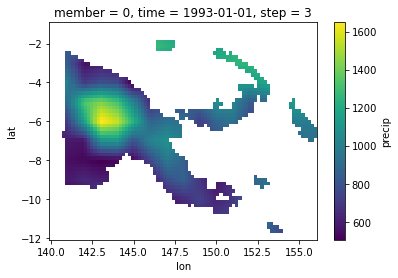

In [57]:
dset.isel(time=0, step=0, member=0)['precip'].plot()

### calculates the regional average (average over lats and lons)

In [58]:
dset_sub = dset.mean(['lat','lon'])

### and the calculates the climatological percentiles 

#### terciles 

In [59]:
clim_p = dset_sub[['precip']].groupby(dset_sub.time.dt.month).apply(calc_percentiles, **{'percentiles':dict_quantiles[quantiles]})

### plot the climatological quantiles as a function of leadtime ('step' dimension)

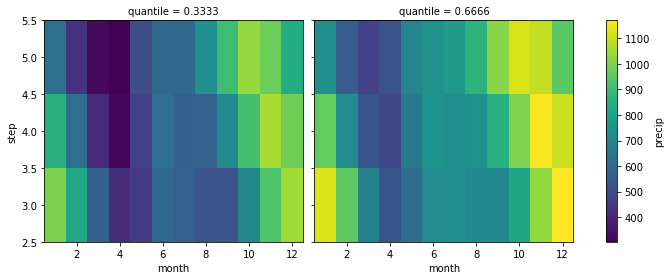

In [60]:
clim_p['precip'].plot(x='month', y = 'step', col='quantile', figsize=(10, 4))

In [61]:
dset_sub

<xarray.Dataset>
Dimensions:  (member: 124, time: 288, step: 3)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 ... 116 117 118 119 120 121 122 123
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
Data variables:
    precip   (time, step, member) float64 894.5 1.189e+03 1.165e+03 ... nan nan
    mask     float64 1.0

In [62]:
clim_p

<xarray.Dataset>
Dimensions:   (month: 12, quantile: 2, step: 3)
Coordinates:
  * step      (step) int64 3 4 5
  * quantile  (quantile) float64 0.3333 0.6666
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip    (month, quantile, step) float64 999.7 850.6 ... 1.096e+03 947.5

### need to save the climatologies 

### digitize: each member is given a category depending on the percentile bins defined earlier 

In [63]:
dset_cat = []

for month in np.arange(12) + 1: 
    
    x = dset_sub.sel(time=(dset_sub.time.dt.month == month))
    
    # drop the missing members 
    
    x = x.dropna('member')
    
    # digitize

    qc = C3S.get_GCM_category_digitize(x, clim_p.sel(month=month), varname='precip', dim='quantile')
    
    dset_cat.append(qc)

### concatenates over the time dimension and reorder 

In [64]:
dset_cat = xr.concat(dset_cat, dim='time')
dset_cat = dset_cat.sortby('time')

In [65]:
dset_cat

<xarray.Dataset>
Dimensions:  (member: 28, time: 288, step: 3)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26 27
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, step, member) float64 1.0 3.0 3.0 1.0 ... nan nan nan nan

### Now calculates the probabilities as the proportion of members falling into each category 

In [66]:
quantiles_category_percent = C3S.calculate_quantiles_probabilities(dset_cat, ncategories=3)

In [67]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 288, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step) float64 32.14 21.43 10.71 ... 25.0 28.57

### because of numerical approximations, sometimes the sum over the quantile dimension is not strictly equal to 100.

In [68]:
np.alltrue((quantiles_category_percent.sum('tercile')['precip'] == 100.))

<xarray.DataArray 'precip' ()>
array(False)

### but it is close enough 

In [69]:
np.alltrue((quantiles_category_percent.sum('tercile')['precip'] >= 99.9999))

<xarray.DataArray 'precip' ()>
array(False)

In [70]:
np.alltrue((quantiles_category_percent.sum('tercile')['precip'] <= 100.0001))

<xarray.DataArray 'precip' ()>
array(True)

In [71]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 288, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step) float64 32.14 21.43 10.71 ... 25.0 28.57

### saves the percentiles in netcdf 

In [72]:
quantiles_category_percent.to_netcdf(outputs_path.joinpath(f"{quantiles}_categories_probabilities_hindcast_{GCM}_{period}_{utils.sanitize_name(shape_name)}.nc"))

### takes the percentile probabilities then casts into a pandas dataframe 

#### these are the leadtimes, in months, should be [1,2,3,4,5] if monthly, [3,4,5] if seasonal 

In [73]:
quantiles_category_percent

<xarray.Dataset>
Dimensions:  (tercile: 3, time: 288, step: 3)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * step     (step) int64 3 4 5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * tercile  (tercile) int64 1 2 3
Data variables:
    precip   (tercile, time, step) float64 32.14 21.43 10.71 ... 25.0 28.57

### transform the xarray dataset into a pandas dataframe with multiindex columns (product of leadtimes and quantiles)

In [74]:
df_quantile_probabilities = []

for step in steps: 
    
    df = quantiles_category_percent.sel(step=step)['precip'].to_pandas().T
    
    cols = pd.MultiIndex.from_product([[step], df.columns]) 

    df.columns = cols 
    
    df_quantile_probabilities.append(df)


In [75]:
df_quantile_probabilities = pd.concat(df_quantile_probabilities, axis=1) 

In [76]:
df_quantile_probabilities.head()

3                                4                        \
tercile             1          2          3          1          2          3   
time                                                                           
1993-01-01  32.142857  42.857143  25.000000  21.428571  32.142857  46.428571   
1993-02-01  28.571429  25.000000  32.142857  17.857143  28.571429  39.285714   
1993-03-01  39.285714  28.571429   3.571429  28.571429  35.714286   7.142857   
1993-04-01  78.571429  14.285714   7.142857  71.428571  21.428571   7.142857   
1993-05-01  64.285714  21.428571   0.000000  35.714286  50.000000   0.000000   

                    5                        
tercile             1          2          3  
time                                         
1993-01-01  10.714286  42.857143  46.428571  
1993-02-01  17.857143  39.285714  28.571429  
1993-03-01  25.000000  35.714286  10.714286  
1993-04-01  60.714286  32.142857   7.142857  
1993-05-01  21.428571  50.000000  14.285714

In [77]:
df_quantile_probabilities.tail()

3                                4                        \
tercile             1          2          3          1          2          3   
time                                                                           
2016-08-01   7.142857  28.571429  50.000000   3.571429  46.428571  35.714286   
2016-09-01   3.571429  28.571429  53.571429  10.714286  35.714286  39.285714   
2016-10-01  10.714286  32.142857  42.857143  39.285714  17.857143  28.571429   
2016-11-01  25.000000  25.000000  35.714286  39.285714  25.000000  21.428571   
2016-12-01  35.714286  21.428571  28.571429  32.142857  28.571429  25.000000   

                    5                        
tercile             1          2          3  
time                                         
2016-08-01  10.714286  28.571429  46.428571  
2016-09-01  25.000000  35.714286  25.000000  
2016-10-01  35.714286  28.571429  21.428571  
2016-11-01  42.857143  17.857143  25.000000  
2016-12-01  32.142857  25.000000  28.571429

### saves to disk 

In [78]:
df_quantile_probabilities.to_csv(outputs_path.joinpath(f"{utils.sanitize_name(shape_name)}_{period}_{GCM}_{quantiles}_probs.csv"))

In [79]:
df_quantile_probabilities

3                                4                        \
tercile             1          2          3          1          2          3   
time                                                                           
1993-01-01  32.142857  42.857143  25.000000  21.428571  32.142857  46.428571   
1993-02-01  28.571429  25.000000  32.142857  17.857143  28.571429  39.285714   
1993-03-01  39.285714  28.571429   3.571429  28.571429  35.714286   7.142857   
1993-04-01  78.571429  14.285714   7.142857  71.428571  21.428571   7.142857   
1993-05-01  64.285714  21.428571   0.000000  35.714286  50.000000   0.000000   
...               ...        ...        ...        ...        ...        ...   
2016-08-01   7.142857  28.571429  50.000000   3.571429  46.428571  35.714286   
2016-09-01   3.571429  28.571429  53.571429  10.714286  35.714286  39.285714   
2016-10-01  10.714286  32.142857  42.857143  39.285714  17.857143  28.571429   
2016-11-01  25.000000  25.000000  35.714286  39.285714  25.000000  21.428571   
2016-12-01  35.714286  21.428571  28.571429  32.142857  28.571429  25.000000   

                    5                        
tercile             1          2          3  
time                                         
1993-01-01  10.714286  42.857143  46.428571  
1993-02-01  17.857143  39.285714  28.571429  
1993-03-01  25.000000  35.714286  10.714286  
1993-04-01  60.714286  32.142857   7.142857  
1993-05-01  21.428571  50.000000  14.285714  
...               ...        ...        ...  
2016-08-01  10.714286  28.571429  46.428571  
2016-09-01  25.000000  35.714286  25.000000  
2016-10-01  35.714286  28.571429  21.428571  
2016-11-01  42.857143  17.857143  25.000000  
2016-12-01  32.142857  25.000000  28.571429  

[288 rows x 9 columns]

### Now we are going to read the ERA5 reanalysis precipitation data for the validation of the regional aggregates 

In [80]:
from ICU_Water_Watch import verification

In [81]:
use_verif = 'era'

In [82]:
dset_obs, dset_anomalies = verification.get_era5()

In [83]:
gcm_domain = domains.get_domain(dset)

In [84]:
gcm_domain

[140.0, 156.0, -12.0, -1.0]

In [85]:
dset_obs = dset_obs.sel(lon=slice(*gcm_domain[:2]), lat=slice(*gcm_domain[2:]))

In [86]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 288, lat: 12, lon: 17)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float64 -12.0 -11.0 -10.0 -9.0 -8.0 ... -4.0 -3.0 -2.0 -1.0
  * lon      (lon) float64 140.0 141.0 142.0 143.0 ... 153.0 154.0 155.0 156.0
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 12, 17), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

### if seasonal, calculates the 3 months accumulations 

In [87]:
if period == 'seasonal': 
    
    dset_obs = dset_obs.rolling({"time":3}, min_periods=3, center=False).sum('time')
    
    dset_obs = dset_obs.isel(time=slice(2, None))

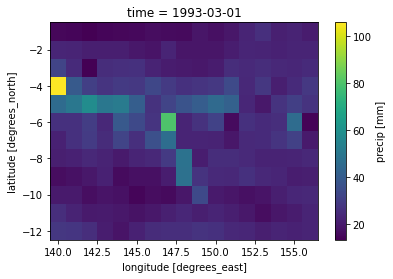

In [88]:
dset_obs['precip'][0,:,:].plot()

In [89]:
dset_obs = dset_obs.interp_like(dset[['lon','lat']])

In [90]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 286, lat: 60, lon: 85)
Coordinates:
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
  * lon      (lon) float64 140.0 140.2 140.4 140.6 ... 155.4 155.6 155.8 156.0
  * lat      (lat) float64 -12.0 -11.81 -11.63 -11.44 ... -1.373 -1.186 -1.0
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 60, 85), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-21 14:37:06 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

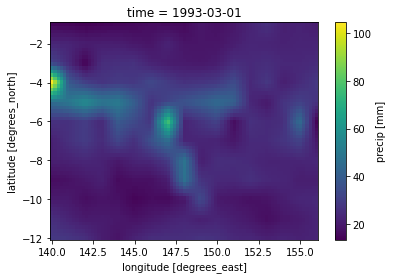

In [91]:
dset_obs['precip'][0,:,:].plot()

### insert the mask from the GCM dataset

In [92]:
dset_obs['mask'] = dset['mask']

### same grid and same mask as the GCM 

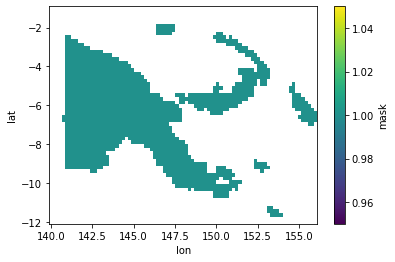

In [93]:
dset['mask'].plot()

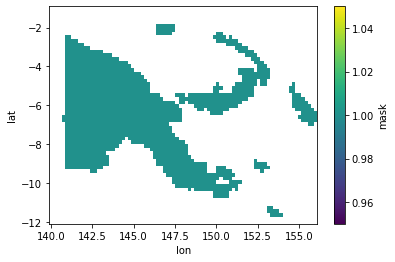

In [94]:
dset_obs['mask'].plot()

### apply the mask 

In [95]:
dset_obs['precip'] = dset_obs['precip'] * dset_obs['mask']

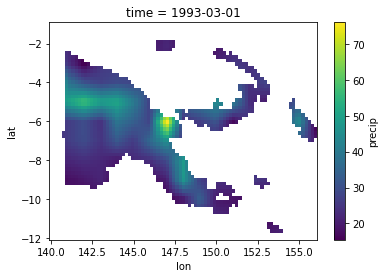

In [96]:
dset_obs.isel(time=0).squeeze()['precip'].plot()

### insert a dummy "member" dimension with one coordinate

In [97]:
dset_obs = dset_obs.expand_dims({'member':[1]})

### calculates the regional average 

In [98]:
dset_obs_sub = dset_obs[['precip']].mean(['lat','lon'])

In [99]:
dset_obs_sub

<xarray.Dataset>
Dimensions:  (member: 1, time: 286)
Coordinates:
  * member   (member) int64 1
  * time     (time) datetime64[ns] 1993-03-01 1993-04-01 ... 2016-12-01
Data variables:
    precip   (member, time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [100]:
dset_obs_sub = dset_obs_sub.chunk({'member':-1, 'time':-1})

In [101]:
with ProgressBar(): 
    dset_obs_sub = dset_obs_sub.compute()

[                                        ] | 0% Completed |  0.0s

[                                        ] | 0% Completed |  0.2s

[                                        ] | 1% Completed |  0.3s

[                                        ] | 2% Completed |  0.4s

[#                                       ] | 3% Completed |  0.5s

[#                                       ] | 4% Completed |  0.6s

[##                                      ] | 5% Completed |  0.7s

[##                                      ] | 6% Completed |  0.8s

[##                                      ] | 6% Completed |  0.9s

[##                                      ] | 7% Completed |  1.0s

[####                                    ] | 11% Completed |  1.1s

[#####                                   ] | 12% Completed |  1.2s

[#####                                   ] | 13% Completed |  1.4s

[#####                                   ] | 14% Completed |  1.5s

[######                                  ] | 15% Completed |  1.6s

[######                                  ] | 16% Completed |  1.7s

[########                                ] | 21% Completed |  1.8s

[#########                               ] | 24% Completed |  1.9s

[##########                              ] | 25% Completed |  2.0s

[##########                              ] | 26% Completed |  2.1s

[###########                             ] | 28% Completed |  2.2s

[#############                           ] | 34% Completed |  2.3s

[################                        ] | 41% Completed |  2.4s

[#################                       ] | 44% Completed |  2.5s

[###################                     ] | 47% Completed |  2.6s

[#####################                   ] | 53% Completed |  2.7s

[#######################                 ] | 59% Completed |  2.8s

[#########################               ] | 63% Completed |  2.9s

[###########################             ] | 67% Completed |  3.0s

[############################            ] | 71% Completed |  3.1s

[################################        ] | 80% Completed |  3.2s

[###################################     ] | 88% Completed |  3.3s

[####################################    ] | 91% Completed |  3.4s

[#####################################   ] | 93% Completed |  3.5s

[######################################  ] | 96% Completed |  3.6s

[########################################] | 100% Completed |  3.7s

### Now calculates the climatological percentiles for the observations, per month 

In [102]:
quantiles

'tercile'

In [103]:
clim_obs_p = dset_obs_sub[['precip']].groupby(dset_obs_sub.time.dt.month).apply(calc_percentiles, **{'percentiles':dict_quantiles[quantiles]})

### Now calculates the categories, based on the observations, for each month or season 

In [104]:
dset_obs_cat = []

for month in np.arange(12) + 1: 
    
    x = dset_obs_sub.sel(time=(dset_obs_sub.time.dt.month == month))

    # digitize

    qc = C3S.get_GCM_category_digitize(x, clim_obs_p.sel(month=month), varname='precip', dim='quantile')
    
    dset_obs_cat.append(qc)

In [105]:
dset_obs_cat = xr.concat(dset_obs_cat, dim='time')

In [106]:
dset_obs_cat = dset_obs_cat.sortby('time')

In [107]:
dset_obs_cat = dset_obs_cat.squeeze()['precip'].to_pandas()

In [108]:
dset_obs_cat

time
1993-03-01    1
1993-04-01    1
1993-05-01    1
1993-06-01    2
1993-07-01    1
             ..
2016-08-01    3
2016-09-01    3
2016-10-01    3
2016-11-01    3
2016-12-01    3
Length: 286, dtype: int64

In [109]:
df_quantile_probabilities

3                                4                        \
tercile             1          2          3          1          2          3   
time                                                                           
1993-01-01  32.142857  42.857143  25.000000  21.428571  32.142857  46.428571   
1993-02-01  28.571429  25.000000  32.142857  17.857143  28.571429  39.285714   
1993-03-01  39.285714  28.571429   3.571429  28.571429  35.714286   7.142857   
1993-04-01  78.571429  14.285714   7.142857  71.428571  21.428571   7.142857   
1993-05-01  64.285714  21.428571   0.000000  35.714286  50.000000   0.000000   
...               ...        ...        ...        ...        ...        ...   
2016-08-01   7.142857  28.571429  50.000000   3.571429  46.428571  35.714286   
2016-09-01   3.571429  28.571429  53.571429  10.714286  35.714286  39.285714   
2016-10-01  10.714286  32.142857  42.857143  39.285714  17.857143  28.571429   
2016-11-01  25.000000  25.000000  35.714286  39.285714  25.000000  21.428571   
2016-12-01  35.714286  21.428571  28.571429  32.142857  28.571429  25.000000   

                    5                        
tercile             1          2          3  
time                                         
1993-01-01  10.714286  42.857143  46.428571  
1993-02-01  17.857143  39.285714  28.571429  
1993-03-01  25.000000  35.714286  10.714286  
1993-04-01  60.714286  32.142857   7.142857  
1993-05-01  21.428571  50.000000  14.285714  
...               ...        ...        ...  
2016-08-01  10.714286  28.571429  46.428571  
2016-09-01  25.000000  35.714286  25.000000  
2016-10-01  35.714286  28.571429  21.428571  
2016-11-01  42.857143  17.857143  25.000000  
2016-12-01  32.142857  25.000000  28.571429  

[288 rows x 9 columns]

In [110]:
df_quantile_probabilities_obs = df_quantile_probabilities.merge(dset_obs_cat.to_frame(name='obs'), left_index=True, right_index=True)

In [111]:
df_quantile_probabilities_obs

,"(3, 1)","(3, 2)","(3, 3)","(4, 1)","(4, 2)","(4, 3)","(5, 1)","(5, 2)","(5, 3)",obs
time,,,,,,,,,,
1993-03-01,39.285714,28.571429,3.571429,28.571429,35.714286,7.142857,25.000000,35.714286,10.714286,1
1993-04-01,78.571429,14.285714,7.142857,71.428571,21.428571,7.142857,60.714286,32.142857,7.142857,1
1993-05-01,64.285714,21.428571,0.000000,35.714286,50.000000,0.000000,21.428571,50.000000,14.285714,1
1993-06-01,50.000000,28.571429,7.142857,39.285714,35.714286,10.714286,35.714286,32.142857,17.857143,2
1993-07-01,28.571429,53.571429,3.571429,21.428571,53.571429,10.714286,7.142857,57.142857,21.428571,1
...,...,...,...,...,...,...,...,...,...,...
2016-08-01,7.142857,28.571429,50.000000,3.571429,46.428571,35.714286,10.714286,28.571429,46.428571,3
2016-09-01,3.571429,28.571429,53.571429,10.714286,35.714286,39.285714,25.000000,35.714286,25.000000,3
2016-10-01,10.714286,32.142857,42.857143,39.285714,17.857143,28.571429,35.714286,28.571429,21.428571,3


In [112]:
df_quantile_probabilities_obs.to_csv(outputs_path.joinpath(f"{utils.sanitize_name(shape_name)}_{period}_{GCM}_{quantiles}_probs_and_obs.csv"))

### Now evaluate the forecasts compared to the observations 

In [113]:
df_quantile_probabilities_obs

,"(3, 1)","(3, 2)","(3, 3)","(4, 1)","(4, 2)","(4, 3)","(5, 1)","(5, 2)","(5, 3)",obs
time,,,,,,,,,,
1993-03-01,39.285714,28.571429,3.571429,28.571429,35.714286,7.142857,25.000000,35.714286,10.714286,1
1993-04-01,78.571429,14.285714,7.142857,71.428571,21.428571,7.142857,60.714286,32.142857,7.142857,1
1993-05-01,64.285714,21.428571,0.000000,35.714286,50.000000,0.000000,21.428571,50.000000,14.285714,1
1993-06-01,50.000000,28.571429,7.142857,39.285714,35.714286,10.714286,35.714286,32.142857,17.857143,2
1993-07-01,28.571429,53.571429,3.571429,21.428571,53.571429,10.714286,7.142857,57.142857,21.428571,1
...,...,...,...,...,...,...,...,...,...,...
2016-08-01,7.142857,28.571429,50.000000,3.571429,46.428571,35.714286,10.714286,28.571429,46.428571,3
2016-09-01,3.571429,28.571429,53.571429,10.714286,35.714286,39.285714,25.000000,35.714286,25.000000,3
2016-10-01,10.714286,32.142857,42.857143,39.285714,17.857143,28.571429,35.714286,28.571429,21.428571,3


In [114]:
def compare(df): 
    acc = (df.forecast == df.obs).sum() / len(df)
    return acc

In [115]:
validation = {}
validation_seasonal = {}

validation[shape_name] = {}
validation_seasonal[shape_name] = {}

for step in steps: 
    
    df_hindcasts = df_quantile_probabilities.xs(step, axis=1, level=0)
    
    df_hindcasts.index = df_hindcasts.index + pd.offsets.MonthBegin(step)
    
    df_hindcasts_most_likely_category = df_hindcasts.idxmax(axis=1)
    
    print(50 * "-")
    print(f"\nrelative frequency of the {quantiles} categories:\n") 
    print(pd.value_counts(df_hindcasts_most_likely_category) / len(df_hindcasts_most_likely_category))
        
    df_merge = pd.concat([df_hindcasts_most_likely_category.to_frame(name='forecast'), dset_obs_cat.to_frame(name='obs')], axis=1).dropna()

    acc = compare(df_merge)
    
    acc_seasonal = df_merge.groupby(df_merge.index.month).apply(compare)
    
    print("\nforecast accuracy\n")
    
    print((df_merge.forecast == df_merge.obs).sum() / len(df_merge))
    
    validation[shape_name][step] = acc 
    
    validation_seasonal[shape_name][step] = acc_seasonal

--------------------------------------------------

relative frequency of the tercile categories:

1    0.385417
3    0.354167
2    0.260417
dtype: float64

forecast accuracy

0.37894736842105264
--------------------------------------------------

relative frequency of the tercile categories:

1    0.378472
3    0.340278
2    0.281250
dtype: float64

forecast accuracy

0.34507042253521125
--------------------------------------------------

relative frequency of the tercile categories:

1    0.388889
3    0.347222
2    0.263889
dtype: float64

forecast accuracy

0.36395759717314485


In [116]:
validation = pd.DataFrame(validation)

In [117]:
validation

,Papua New Guinea
3,0.378947
4,0.345070
5,0.363958


In [118]:
validation.to_csv(outputs_path.joinpath(f"validation_{utils.sanitize_name(shape_name)}_{period}_{GCM}_{quantiles}.csv"))

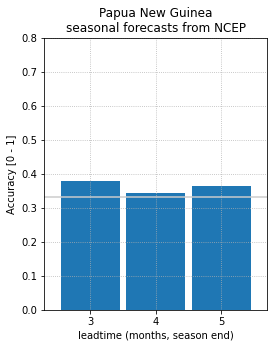

In [119]:
f = validation.plot(kind='bar', ylabel='Accuracy [0 - 1]', xlabel='leadtime (months, season end)', ylim=[None, 0.8], legend=None, figsize=(4,5), width=0.9) 
f.axes.set_title(f"{shape_name}\n{period} forecasts from {GCM}")
f.axes.axhline(0.3333, color='0.8')
f.axes.grid(ls=':')
[l.set_rotation(0) for l in f.axes.xaxis.get_ticklabels()]
fig = plt.gcf()
fig.savefig(fig_path.joinpath(f'{utils.sanitize_name(shape_name)}_{period}_{GCM}_{quantiles}_probs.png'), dpi=200, bbox_inches='tight', facecolor='w')